In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset

dataset = load_dataset('emotion')

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something', 0)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


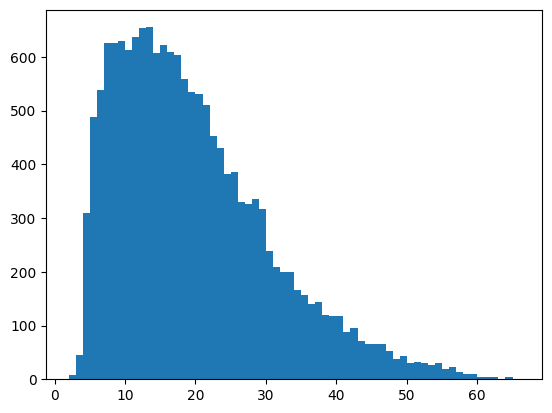

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

In [14]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [15]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [16]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


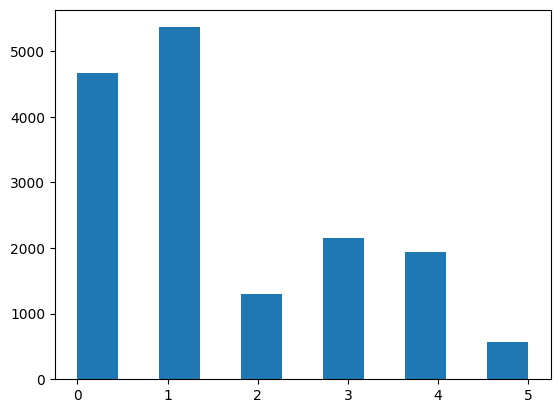

In [17]:
plt.hist(labels, bins=11)
plt.show()

In [18]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [19]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [20]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=40),
    tf.keras.layers.GRU(64, return_sequences=True),  # first GRU layer
    tf.keras.layers.GRU(32),                          # second GRU layer
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [23]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', np.int64(4))

In [24]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3339 - loss: 1.6031 - val_accuracy: 0.3520 - val_loss: 1.5801
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3352 - loss: 1.5700 - val_accuracy: 0.4870 - val_loss: 1.3203
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6758 - loss: 0.9209 - val_accuracy: 0.8585 - val_loss: 0.4797
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8725 - loss: 0.3947 - val_accuracy: 0.8930 - val_loss: 0.3624
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9184 - loss: 0.2427 - val_accuracy: 0.9040 - val_loss: 0.2646
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9339 - loss: 0.1763 - val_accuracy: 0.9105 - val_loss: 0.2353
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9445 - loss: 0.1380 - val_accuracy: 0.9105 - val_loss: 0.2300
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9551 - loss: 0.1090 - val_accuracy: 0

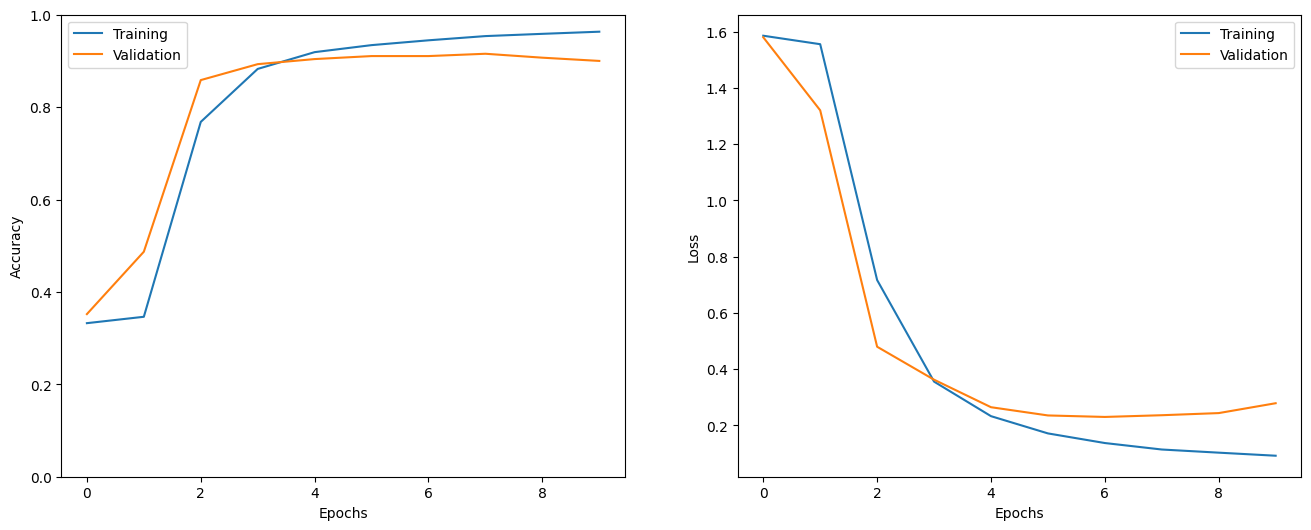

In [25]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [26]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [27]:
eval = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9021 - loss: 0.2703


In [28]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(test_sequences)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(test_labels)
print(type(y_pred))
print(type(y_true))


print(classification_report(y_true, y_pred, target_names=list(['0','1','2','3','4','5'])))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       581
           1       0.94      0.92      0.93       695
           2       0.74      0.84      0.79       159
           3       0.86      0.94      0.90       275
           4       0.86      0.89      0.87       224
           5       0.76      0.58      0.66        66

    accuracy                           0.90      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.91      0.90      0.90      2000



In [29]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  # Get the index of the predicted emotion
  predicted_emotion_index = np.argmax(p)

  print('Predicted Emotion:', index_to_classes.get(predicted_emotion_index), '\n')

Tweet: i feel tortured delilahlwl am considering i had one the other day about one of my closest friends raping and killing chicks
Actual Emotion: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Emotion: 3 

Tweet: i feel like now its more of sweet apple now
Actual Emotion: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Emotion: 2 

Tweet: i just feel are ludicrous and wasting space or so trite they should have looked at the book first and come up with something a little more original
Actual Emotion: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Emotion: 3 

Tweet: i have the joy of allowing kids to feel like the valued treasures that they are and to just have a blast being a kid alongside with them but can i just say its an incredibly humbling experience to have influence into a childs life and to know that what you do and say is being internalized
Actual Emotion: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Emotion: 1 

Tweet: i really like this person feel that the que